## Introduction

The intention of this notebook is to utilize tensorflow to build a neural network that helps to predict default likelihood, and to visualize some of the insights generated from the study


## Dependencies

Below the data and some external libraries are imported to begin the process


In [7]:
#%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from sklearn import preprocessing
import matplotlib.pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import metric_spec
from tensorflow.contrib.learn.python.learn.estimators import _sklearn
from tensorflow.contrib.learn.python.learn.estimators import estimator
from tensorflow.contrib.learn.python.learn.estimators import model_fn
from tensorflow.python.framework import ops
from tensorflow.python.saved_model import loader
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.util import compat
tf.logging.set_verbosity(tf.logging.FATAL) 

In [8]:
df = pd.read_csv('/home/alam/Downloads/DataNew.csv')


## Creating the Target Label

From a prior notebook, I examined the 'loan_status' column. The cell below creates a column with binary value 0 for loans not in default, and binary value 1 for loans in default.


In [65]:
df['Default_Binary'] = int(0)
for index, value in df.Default_On_Payment.iteritems():
    if value == 'Default':
        df.set_value(index,'Default_Binary',int(1))
    if value == 'Charged Off':
        df.set_value(index, 'Default_Binary',int(1))
    if value == 'Late (31-120 days)':
        df.set_value(index, 'Default_Binary',int(1))    
    if value == 'Late (16-30 days)':
        df.set_value(index, 'Default_Binary',int(1))
    if value == 'Does not meet the credit policy. Status:Charged Off':
        df.set_value(index, 'Default_Binary',int(1))  


## Creating a category feature for "Loan Purpose"

Below I create a new column for loan purpose, and assign each type of loan purpose an integer value.


In [66]:
df['Purpose_Cat'] = int(0) 
for index, value in df.Purpose_Credit_Taken.iteritems():
    if value == 'Vehicle':
        df.set_value(index,'Purpose_Cat',int(1))
    if value == 'Furniture':
        df.set_value(index, 'Purpose_Cat',int(2))
    if value == 'Electronics Appliances':
        df.set_value(index, 'Purpose_Cat',int(3))    
    if value == 'Vacation':
        df.set_value(index, 'Purpose_Cat',int(4))    
    if value == 'Repairs':
        df.set_value(index,'Purpose_Cat',int(5))
    if value == 'Remodeling house':
        df.set_value(index, 'Purpose_Cat',int(6))
    if value == 'Education':
        df.set_value(index, 'Purpose_Cat',int(7))    
    if value == 'Training':
        df.set_value(index, 'Purpose_Cat',int(8))   
    if value == 'Business':
        df.set_value(index, 'Purpose_Cat',int(9))    
    if value == 'Others':
        df.set_value(index,'Purpose_Cat',int(10))
    

## Scaling Number Credit


In [54]:
#x = np.array(df.Num_Dependents.values).reshape(-1,1) 
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#df['Num_Dependents_scaled'] = pd.DataFrame(x_scaled)
#print (df.Credit_Amount_scaled[0:5])


## Scaling Loan Amount

Below I scale the amount funded for each loan to a value between 0 and 1



In [67]:
x = np.array(df.Credit_Amount.values).reshape(-1,1) 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['Credit_Amount_scaled'] = pd.DataFrame(x_scaled)
print (df.Credit_Amount_scaled[0:5])

0    0.202982
1    0.085012
2    0.324254
3    0.133432
4    0.667932
Name: Credit_Amount_scaled, dtype: float64



## Setting up the Neural Network

Below I split the data into a training, testing, and prediction set

After that, I assign the feature and target columns, and create the function that will be used to pass the data into the model


In [15]:
training_set = df[0:3000] # Train on first 500k rows
testing_set = df[3001:4500] # Test on next 350k rows
prediction_set = df[4500:] # Predict on final 37k rows

In [68]:
COLUMNS = ['Purpose_Cat','Credit_Amount_scaled','Default_Binary']          
FEATURES = ['Purpose_Cat','Credit_Amount_scaled']
LABEL = 'Default_Binary'

In [69]:
def input_fn(data_set):
    feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES} 
    labels = tf.constant(data_set[LABEL].values)
    return feature_cols, labels

## Fitting The Model 

In [70]:
feature_cols = [tf.contrib.layers.real_valued_column(k)
              for k in FEATURES]
#config = tf.contrib.learn.RunConfig(keep_checkpoint_max=1) ######## DO NOT DELETE
regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_cols, hidden_units=[10, 20, 10], ) 
regressor.fit(input_fn=lambda: input_fn(training_set), steps=251)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f11abb454d0>, 'hidden_units': [10, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='Purpose_Cat', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Credit_Amount_scaled', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)), 'embedding_lr_multipliers': None, 'optimizer': None, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x7f11b7b10488>, 'input_layer_min_slice_size': None})

## Evaluating the Model 

In [71]:
# Score accuracy
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=10)
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))

Loss: 0.000006


## Predicting on new data 

In [72]:
y = regressor.predict(input_fn=lambda: input_fn(prediction_set))
predictions = list(itertools.islice(y, 500))


## Visualize Predictions Relative to Loan Purpose 

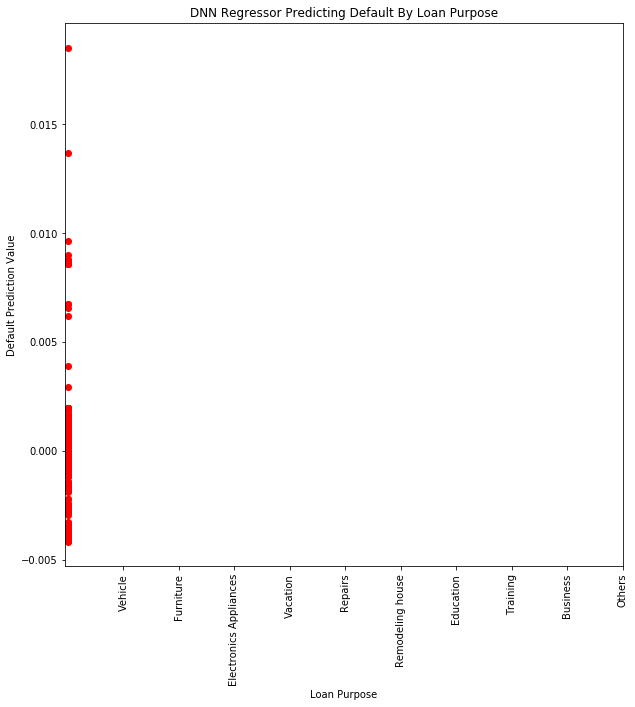

In [73]:
plt.plot(prediction_set.Purpose_Cat, predictions, 'ro')
plt.ylabel("Default Prediction Value")
plt.xlabel("Loan Purpose")
plt.title("DNN Regressor Predicting Default By Loan Purpose")
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
labels = ['Vehicle', 'Furniture', 'Electronics Appliances', 'Vacation',
         'Repairs', 'Remodeling house', 'Education', 'Training',
         'Business', 'Others'
         ]

plt.xticks([1,2,3,4,5,6,7,8,9,10], labels, rotation='vertical')

plt.show()

## Visualize Predictions Relative to Loan Size 

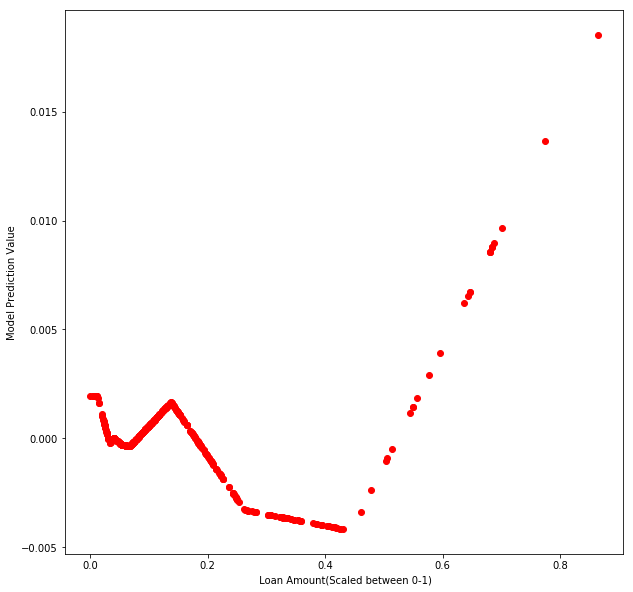

In [74]:
plt.plot(prediction_set.Credit_Amount_scaled, predictions, 'ro')
plt.ylabel("Model Prediction Value")
plt.xlabel(" Loan Amount(Scaled between 0-1)")
plt.show()